# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


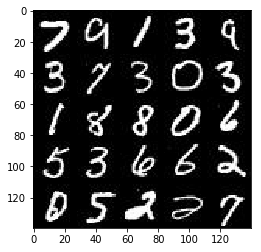

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

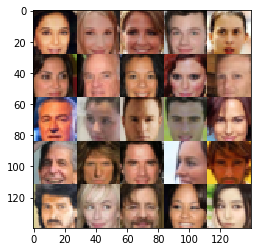

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get trainable variables
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build the model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Scale images to -1 to 1 (inputs are -0.5 to 0.5)
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                # Adding 2 more generator optimizers was suggested by someone in Slack
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 4.4044
Epoch 1/2... Discriminator Loss: 2.4729... Generator Loss: 0.3520
Epoch 1/2... Discriminator Loss: 2.5940... Generator Loss: 0.2867
Epoch 1/2... Discriminator Loss: 2.2118... Generator Loss: 0.3147
Epoch 1/2... Discriminator Loss: 2.0798... Generator Loss: 0.3311
Epoch 1/2... Discriminator Loss: 1.8941... Generator Loss: 0.5513
Epoch 1/2... Discriminator Loss: 2.2017... Generator Loss: 0.4850
Epoch 1/2... Discriminator Loss: 1.9178... Generator Loss: 0.3431
Epoch 1/2... Discriminator Loss: 1.6989... Generator Loss: 0.6056
Epoch 1/2... Discriminator Loss: 1.8516... Generator Loss: 0.3125


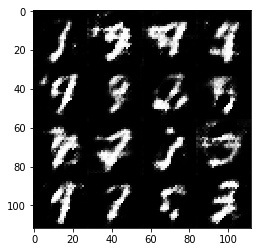

Epoch 1/2... Discriminator Loss: 2.0867... Generator Loss: 0.8428
Epoch 1/2... Discriminator Loss: 1.8544... Generator Loss: 0.2836
Epoch 1/2... Discriminator Loss: 2.0013... Generator Loss: 0.3430
Epoch 1/2... Discriminator Loss: 1.5084... Generator Loss: 0.7116
Epoch 1/2... Discriminator Loss: 1.7964... Generator Loss: 0.8372
Epoch 1/2... Discriminator Loss: 1.5985... Generator Loss: 0.6730
Epoch 1/2... Discriminator Loss: 2.0953... Generator Loss: 0.8265
Epoch 1/2... Discriminator Loss: 1.8135... Generator Loss: 0.5916
Epoch 1/2... Discriminator Loss: 1.7811... Generator Loss: 0.7438
Epoch 1/2... Discriminator Loss: 1.5317... Generator Loss: 0.5108


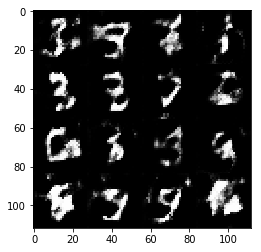

Epoch 1/2... Discriminator Loss: 1.7238... Generator Loss: 0.4508
Epoch 1/2... Discriminator Loss: 1.8967... Generator Loss: 0.2321
Epoch 1/2... Discriminator Loss: 1.5919... Generator Loss: 0.5350
Epoch 1/2... Discriminator Loss: 1.8418... Generator Loss: 0.4710
Epoch 1/2... Discriminator Loss: 1.7564... Generator Loss: 0.3434
Epoch 1/2... Discriminator Loss: 1.7015... Generator Loss: 0.3435
Epoch 1/2... Discriminator Loss: 1.6130... Generator Loss: 0.3942
Epoch 1/2... Discriminator Loss: 1.6091... Generator Loss: 0.5199
Epoch 1/2... Discriminator Loss: 1.6008... Generator Loss: 0.3461
Epoch 1/2... Discriminator Loss: 1.7400... Generator Loss: 0.2979


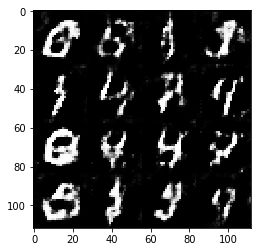

Epoch 1/2... Discriminator Loss: 1.6154... Generator Loss: 0.7531
Epoch 1/2... Discriminator Loss: 1.6485... Generator Loss: 0.4628
Epoch 1/2... Discriminator Loss: 1.7369... Generator Loss: 0.4975
Epoch 1/2... Discriminator Loss: 1.5123... Generator Loss: 0.6371
Epoch 1/2... Discriminator Loss: 1.6022... Generator Loss: 0.3960
Epoch 1/2... Discriminator Loss: 1.5804... Generator Loss: 0.5931
Epoch 1/2... Discriminator Loss: 1.4746... Generator Loss: 0.5631
Epoch 1/2... Discriminator Loss: 1.7655... Generator Loss: 1.1262
Epoch 1/2... Discriminator Loss: 1.6424... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 1.5999... Generator Loss: 0.3934


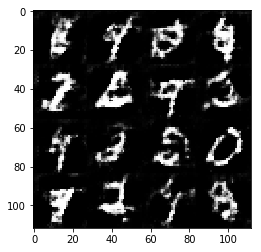

Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 0.4845
Epoch 1/2... Discriminator Loss: 1.7252... Generator Loss: 0.3744
Epoch 1/2... Discriminator Loss: 1.5662... Generator Loss: 0.5036
Epoch 1/2... Discriminator Loss: 1.8185... Generator Loss: 0.2459
Epoch 1/2... Discriminator Loss: 1.7160... Generator Loss: 0.3210
Epoch 1/2... Discriminator Loss: 1.7116... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 1.6191... Generator Loss: 0.4503
Epoch 1/2... Discriminator Loss: 1.4630... Generator Loss: 0.7954
Epoch 1/2... Discriminator Loss: 1.5209... Generator Loss: 0.5835
Epoch 1/2... Discriminator Loss: 1.7027... Generator Loss: 0.8573


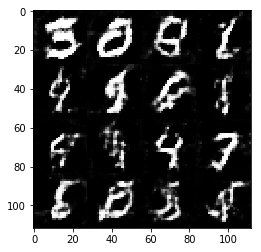

Epoch 1/2... Discriminator Loss: 1.5544... Generator Loss: 0.6442
Epoch 1/2... Discriminator Loss: 1.5278... Generator Loss: 0.6936
Epoch 1/2... Discriminator Loss: 1.7205... Generator Loss: 0.4158
Epoch 1/2... Discriminator Loss: 1.5316... Generator Loss: 0.4965
Epoch 1/2... Discriminator Loss: 1.8417... Generator Loss: 0.2319
Epoch 1/2... Discriminator Loss: 1.5492... Generator Loss: 0.6150
Epoch 1/2... Discriminator Loss: 1.6453... Generator Loss: 0.9034
Epoch 1/2... Discriminator Loss: 1.4941... Generator Loss: 0.6233
Epoch 1/2... Discriminator Loss: 1.6397... Generator Loss: 0.4915
Epoch 1/2... Discriminator Loss: 1.6405... Generator Loss: 0.6223


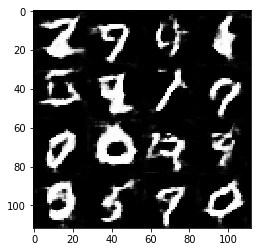

Epoch 1/2... Discriminator Loss: 1.5096... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 1.7888... Generator Loss: 0.2875
Epoch 1/2... Discriminator Loss: 1.9154... Generator Loss: 0.2241
Epoch 1/2... Discriminator Loss: 1.5394... Generator Loss: 0.5986
Epoch 1/2... Discriminator Loss: 1.7431... Generator Loss: 0.3247
Epoch 1/2... Discriminator Loss: 1.7598... Generator Loss: 0.3212
Epoch 1/2... Discriminator Loss: 1.5169... Generator Loss: 0.6660
Epoch 1/2... Discriminator Loss: 1.5627... Generator Loss: 1.0754
Epoch 1/2... Discriminator Loss: 1.6704... Generator Loss: 0.3677
Epoch 1/2... Discriminator Loss: 2.0176... Generator Loss: 0.1807


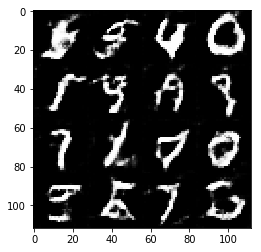

Epoch 1/2... Discriminator Loss: 1.5174... Generator Loss: 0.6136
Epoch 1/2... Discriminator Loss: 1.5739... Generator Loss: 0.4271
Epoch 1/2... Discriminator Loss: 1.5990... Generator Loss: 0.7128
Epoch 1/2... Discriminator Loss: 1.6614... Generator Loss: 0.4979
Epoch 1/2... Discriminator Loss: 1.5646... Generator Loss: 0.5939
Epoch 1/2... Discriminator Loss: 1.6184... Generator Loss: 0.4432
Epoch 1/2... Discriminator Loss: 1.5539... Generator Loss: 0.4344
Epoch 1/2... Discriminator Loss: 1.7489... Generator Loss: 0.3139
Epoch 1/2... Discriminator Loss: 1.6339... Generator Loss: 0.4995
Epoch 1/2... Discriminator Loss: 1.6399... Generator Loss: 0.5284


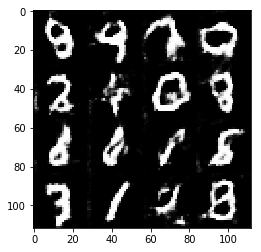

Epoch 1/2... Discriminator Loss: 1.5880... Generator Loss: 0.5437
Epoch 1/2... Discriminator Loss: 1.6486... Generator Loss: 0.3105
Epoch 1/2... Discriminator Loss: 1.6487... Generator Loss: 0.6926
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.5065
Epoch 1/2... Discriminator Loss: 1.6001... Generator Loss: 0.7135
Epoch 1/2... Discriminator Loss: 1.7566... Generator Loss: 0.5300
Epoch 1/2... Discriminator Loss: 1.5455... Generator Loss: 0.5013
Epoch 1/2... Discriminator Loss: 1.5870... Generator Loss: 0.4977
Epoch 1/2... Discriminator Loss: 1.6347... Generator Loss: 0.6917
Epoch 1/2... Discriminator Loss: 1.6168... Generator Loss: 0.5723


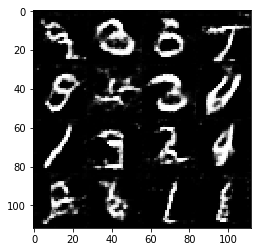

Epoch 1/2... Discriminator Loss: 1.5257... Generator Loss: 0.7549
Epoch 1/2... Discriminator Loss: 1.5593... Generator Loss: 0.5060
Epoch 1/2... Discriminator Loss: 1.5051... Generator Loss: 0.5522
Epoch 1/2... Discriminator Loss: 1.5362... Generator Loss: 0.6705
Epoch 1/2... Discriminator Loss: 1.5734... Generator Loss: 0.3592
Epoch 1/2... Discriminator Loss: 1.6939... Generator Loss: 0.3680
Epoch 1/2... Discriminator Loss: 2.0683... Generator Loss: 0.1810
Epoch 1/2... Discriminator Loss: 1.7007... Generator Loss: 0.5293
Epoch 1/2... Discriminator Loss: 1.8389... Generator Loss: 0.2349
Epoch 1/2... Discriminator Loss: 1.5775... Generator Loss: 0.4762


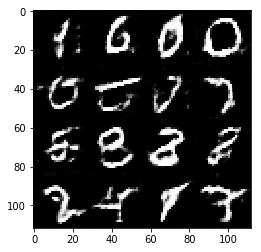

Epoch 1/2... Discriminator Loss: 1.5441... Generator Loss: 0.6449
Epoch 1/2... Discriminator Loss: 1.6283... Generator Loss: 0.3435
Epoch 1/2... Discriminator Loss: 1.4652... Generator Loss: 0.8043
Epoch 1/2... Discriminator Loss: 1.5743... Generator Loss: 0.4028
Epoch 1/2... Discriminator Loss: 2.4817... Generator Loss: 0.1087
Epoch 1/2... Discriminator Loss: 1.5083... Generator Loss: 0.6210
Epoch 1/2... Discriminator Loss: 1.5595... Generator Loss: 0.4331
Epoch 1/2... Discriminator Loss: 1.5572... Generator Loss: 0.5196
Epoch 1/2... Discriminator Loss: 2.2664... Generator Loss: 0.1354
Epoch 1/2... Discriminator Loss: 1.9447... Generator Loss: 0.2668


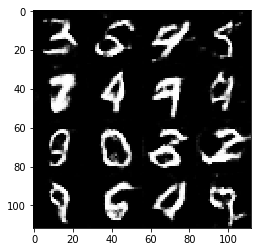

Epoch 1/2... Discriminator Loss: 1.8514... Generator Loss: 0.2789
Epoch 1/2... Discriminator Loss: 1.7993... Generator Loss: 0.4212
Epoch 1/2... Discriminator Loss: 2.0215... Generator Loss: 0.1952
Epoch 1/2... Discriminator Loss: 1.6993... Generator Loss: 0.5258
Epoch 1/2... Discriminator Loss: 1.6631... Generator Loss: 0.3897
Epoch 1/2... Discriminator Loss: 1.6029... Generator Loss: 0.4152
Epoch 1/2... Discriminator Loss: 1.5139... Generator Loss: 0.6411
Epoch 1/2... Discriminator Loss: 1.8872... Generator Loss: 0.2178
Epoch 1/2... Discriminator Loss: 1.6070... Generator Loss: 0.3728
Epoch 1/2... Discriminator Loss: 1.7141... Generator Loss: 0.3016


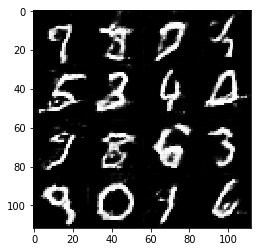

Epoch 1/2... Discriminator Loss: 1.5938... Generator Loss: 0.7401
Epoch 1/2... Discriminator Loss: 1.6671... Generator Loss: 0.3372
Epoch 1/2... Discriminator Loss: 1.6501... Generator Loss: 0.3934
Epoch 1/2... Discriminator Loss: 1.6099... Generator Loss: 0.4161
Epoch 1/2... Discriminator Loss: 1.9264... Generator Loss: 0.2761
Epoch 1/2... Discriminator Loss: 1.6424... Generator Loss: 0.4630
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 1.5060... Generator Loss: 0.5870
Epoch 1/2... Discriminator Loss: 1.8300... Generator Loss: 0.3319
Epoch 1/2... Discriminator Loss: 1.5833... Generator Loss: 0.3908


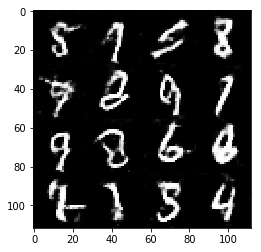

Epoch 1/2... Discriminator Loss: 1.8089... Generator Loss: 0.3231
Epoch 1/2... Discriminator Loss: 1.5397... Generator Loss: 0.5335
Epoch 1/2... Discriminator Loss: 1.7097... Generator Loss: 0.4011
Epoch 1/2... Discriminator Loss: 1.5618... Generator Loss: 0.4900
Epoch 1/2... Discriminator Loss: 1.5722... Generator Loss: 0.4289
Epoch 1/2... Discriminator Loss: 2.1244... Generator Loss: 0.1700
Epoch 1/2... Discriminator Loss: 1.6359... Generator Loss: 0.3275
Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 0.6603
Epoch 1/2... Discriminator Loss: 1.8967... Generator Loss: 0.2857
Epoch 1/2... Discriminator Loss: 1.8360... Generator Loss: 0.2391


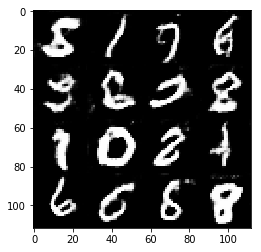

Epoch 1/2... Discriminator Loss: 1.7188... Generator Loss: 0.3211
Epoch 1/2... Discriminator Loss: 1.4652... Generator Loss: 0.4927
Epoch 1/2... Discriminator Loss: 1.5612... Generator Loss: 0.4345
Epoch 1/2... Discriminator Loss: 2.0053... Generator Loss: 0.1978
Epoch 1/2... Discriminator Loss: 1.7745... Generator Loss: 0.3570
Epoch 1/2... Discriminator Loss: 1.6234... Generator Loss: 0.3527
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 0.7761
Epoch 1/2... Discriminator Loss: 1.5250... Generator Loss: 0.8024
Epoch 1/2... Discriminator Loss: 1.6943... Generator Loss: 0.4247
Epoch 1/2... Discriminator Loss: 1.6214... Generator Loss: 0.4735


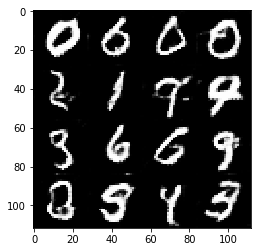

Epoch 1/2... Discriminator Loss: 1.7082... Generator Loss: 0.3758
Epoch 1/2... Discriminator Loss: 1.9087... Generator Loss: 0.2101
Epoch 1/2... Discriminator Loss: 2.0718... Generator Loss: 0.2183
Epoch 1/2... Discriminator Loss: 1.6665... Generator Loss: 0.5830
Epoch 1/2... Discriminator Loss: 1.5953... Generator Loss: 0.4010
Epoch 1/2... Discriminator Loss: 1.7392... Generator Loss: 0.2893
Epoch 1/2... Discriminator Loss: 1.6727... Generator Loss: 0.4287
Epoch 1/2... Discriminator Loss: 1.8157... Generator Loss: 0.2923
Epoch 1/2... Discriminator Loss: 1.5423... Generator Loss: 0.5762
Epoch 1/2... Discriminator Loss: 1.9415... Generator Loss: 0.4706


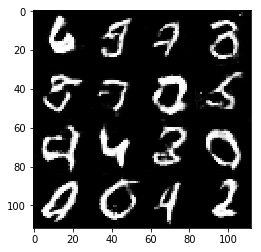

Epoch 1/2... Discriminator Loss: 1.5942... Generator Loss: 0.4562
Epoch 1/2... Discriminator Loss: 1.8920... Generator Loss: 0.2220
Epoch 1/2... Discriminator Loss: 1.5857... Generator Loss: 0.3559
Epoch 1/2... Discriminator Loss: 1.6817... Generator Loss: 0.5107
Epoch 1/2... Discriminator Loss: 1.7538... Generator Loss: 0.3808
Epoch 1/2... Discriminator Loss: 1.8530... Generator Loss: 0.3603
Epoch 1/2... Discriminator Loss: 1.7239... Generator Loss: 0.3362
Epoch 1/2... Discriminator Loss: 2.2819... Generator Loss: 0.1519
Epoch 1/2... Discriminator Loss: 1.6195... Generator Loss: 0.3530
Epoch 1/2... Discriminator Loss: 1.7012... Generator Loss: 0.4537


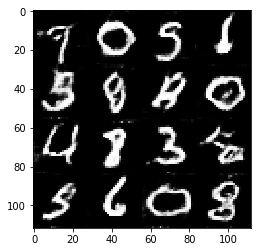

Epoch 1/2... Discriminator Loss: 1.7103... Generator Loss: 0.2682
Epoch 1/2... Discriminator Loss: 1.8559... Generator Loss: 0.2439
Epoch 1/2... Discriminator Loss: 1.6872... Generator Loss: 0.3662
Epoch 1/2... Discriminator Loss: 1.7970... Generator Loss: 0.2573
Epoch 1/2... Discriminator Loss: 1.9046... Generator Loss: 1.6691
Epoch 1/2... Discriminator Loss: 1.9062... Generator Loss: 0.2672
Epoch 1/2... Discriminator Loss: 1.2248... Generator Loss: 1.1550
Epoch 1/2... Discriminator Loss: 2.0390... Generator Loss: 0.2347
Epoch 1/2... Discriminator Loss: 1.6969... Generator Loss: 0.5930
Epoch 1/2... Discriminator Loss: 1.7333... Generator Loss: 0.4707


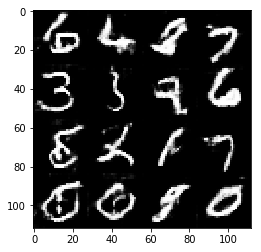

Epoch 1/2... Discriminator Loss: 2.2019... Generator Loss: 0.1598
Epoch 1/2... Discriminator Loss: 1.9701... Generator Loss: 0.2810
Epoch 1/2... Discriminator Loss: 1.5989... Generator Loss: 0.3819
Epoch 1/2... Discriminator Loss: 1.5576... Generator Loss: 0.3646
Epoch 1/2... Discriminator Loss: 1.8774... Generator Loss: 0.2398
Epoch 1/2... Discriminator Loss: 1.9121... Generator Loss: 0.4085
Epoch 1/2... Discriminator Loss: 2.9718... Generator Loss: 0.0617
Epoch 2/2... Discriminator Loss: 1.9507... Generator Loss: 0.2291
Epoch 2/2... Discriminator Loss: 1.6201... Generator Loss: 0.5451
Epoch 2/2... Discriminator Loss: 1.5696... Generator Loss: 0.6607


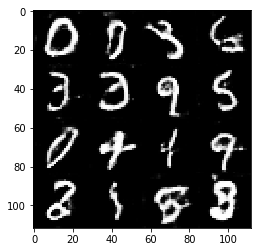

Epoch 2/2... Discriminator Loss: 1.8330... Generator Loss: 0.2724
Epoch 2/2... Discriminator Loss: 1.6651... Generator Loss: 0.3156
Epoch 2/2... Discriminator Loss: 1.4935... Generator Loss: 0.5734
Epoch 2/2... Discriminator Loss: 1.5437... Generator Loss: 0.4141
Epoch 2/2... Discriminator Loss: 2.5745... Generator Loss: 0.1047
Epoch 2/2... Discriminator Loss: 1.7838... Generator Loss: 0.3738
Epoch 2/2... Discriminator Loss: 1.9380... Generator Loss: 0.2318
Epoch 2/2... Discriminator Loss: 1.8007... Generator Loss: 0.4189
Epoch 2/2... Discriminator Loss: 2.0474... Generator Loss: 0.3854
Epoch 2/2... Discriminator Loss: 1.8627... Generator Loss: 0.2711


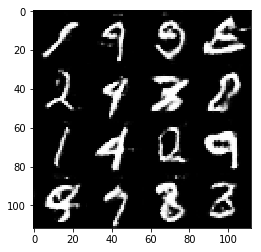

Epoch 2/2... Discriminator Loss: 2.2687... Generator Loss: 0.1432
Epoch 2/2... Discriminator Loss: 1.6071... Generator Loss: 0.3642
Epoch 2/2... Discriminator Loss: 2.1539... Generator Loss: 0.1704
Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.6137
Epoch 2/2... Discriminator Loss: 1.6805... Generator Loss: 0.4233
Epoch 2/2... Discriminator Loss: 2.1021... Generator Loss: 0.1792
Epoch 2/2... Discriminator Loss: 1.8721... Generator Loss: 0.2447
Epoch 2/2... Discriminator Loss: 1.8623... Generator Loss: 0.4191
Epoch 2/2... Discriminator Loss: 1.6280... Generator Loss: 0.4305
Epoch 2/2... Discriminator Loss: 2.0648... Generator Loss: 0.8385


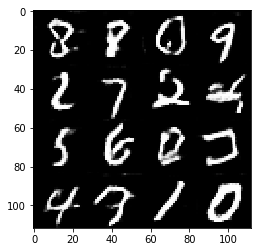

Epoch 2/2... Discriminator Loss: 1.6824... Generator Loss: 0.7335
Epoch 2/2... Discriminator Loss: 1.6847... Generator Loss: 0.3383
Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.5872
Epoch 2/2... Discriminator Loss: 1.5154... Generator Loss: 0.7414
Epoch 2/2... Discriminator Loss: 2.4787... Generator Loss: 0.1182
Epoch 2/2... Discriminator Loss: 1.4558... Generator Loss: 0.4553
Epoch 2/2... Discriminator Loss: 1.7173... Generator Loss: 0.3640
Epoch 2/2... Discriminator Loss: 2.2634... Generator Loss: 0.1414
Epoch 2/2... Discriminator Loss: 1.6930... Generator Loss: 0.4959
Epoch 2/2... Discriminator Loss: 1.6184... Generator Loss: 0.3459


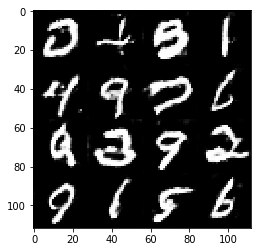

Epoch 2/2... Discriminator Loss: 1.7049... Generator Loss: 0.3447
Epoch 2/2... Discriminator Loss: 1.9665... Generator Loss: 0.2721
Epoch 2/2... Discriminator Loss: 2.1930... Generator Loss: 0.1876
Epoch 2/2... Discriminator Loss: 1.9529... Generator Loss: 0.2291
Epoch 2/2... Discriminator Loss: 1.7981... Generator Loss: 0.3258
Epoch 2/2... Discriminator Loss: 1.8068... Generator Loss: 0.6705
Epoch 2/2... Discriminator Loss: 2.0012... Generator Loss: 0.2126
Epoch 2/2... Discriminator Loss: 1.5716... Generator Loss: 0.3515
Epoch 2/2... Discriminator Loss: 1.8654... Generator Loss: 0.2579
Epoch 2/2... Discriminator Loss: 2.3896... Generator Loss: 0.1320


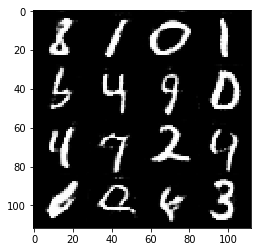

Epoch 2/2... Discriminator Loss: 2.1117... Generator Loss: 0.1974
Epoch 2/2... Discriminator Loss: 1.5200... Generator Loss: 0.3196
Epoch 2/2... Discriminator Loss: 1.8117... Generator Loss: 0.3033
Epoch 2/2... Discriminator Loss: 1.6349... Generator Loss: 0.4461
Epoch 2/2... Discriminator Loss: 1.9867... Generator Loss: 0.2219
Epoch 2/2... Discriminator Loss: 1.9648... Generator Loss: 0.2959
Epoch 2/2... Discriminator Loss: 2.0235... Generator Loss: 0.5327
Epoch 2/2... Discriminator Loss: 1.9495... Generator Loss: 0.2364
Epoch 2/2... Discriminator Loss: 2.2490... Generator Loss: 0.1989
Epoch 2/2... Discriminator Loss: 2.3496... Generator Loss: 0.1658


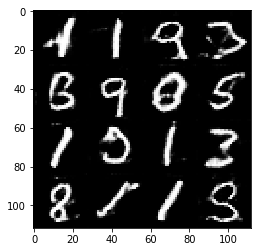

Epoch 2/2... Discriminator Loss: 1.9967... Generator Loss: 0.2352
Epoch 2/2... Discriminator Loss: 1.7841... Generator Loss: 0.7159
Epoch 2/2... Discriminator Loss: 1.9456... Generator Loss: 0.2258
Epoch 2/2... Discriminator Loss: 2.5755... Generator Loss: 0.1209
Epoch 2/2... Discriminator Loss: 1.5754... Generator Loss: 0.3813
Epoch 2/2... Discriminator Loss: 1.5773... Generator Loss: 0.5309
Epoch 2/2... Discriminator Loss: 1.7443... Generator Loss: 0.3264
Epoch 2/2... Discriminator Loss: 1.7842... Generator Loss: 1.3966
Epoch 2/2... Discriminator Loss: 2.4706... Generator Loss: 0.1088
Epoch 2/2... Discriminator Loss: 2.2771... Generator Loss: 0.1379


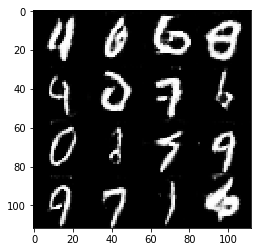

Epoch 2/2... Discriminator Loss: 2.6313... Generator Loss: 0.1276
Epoch 2/2... Discriminator Loss: 1.9735... Generator Loss: 0.2981
Epoch 2/2... Discriminator Loss: 2.9025... Generator Loss: 0.0819
Epoch 2/2... Discriminator Loss: 2.0129... Generator Loss: 0.3188
Epoch 2/2... Discriminator Loss: 1.9305... Generator Loss: 0.2826
Epoch 2/2... Discriminator Loss: 1.9016... Generator Loss: 0.2685
Epoch 2/2... Discriminator Loss: 2.0139... Generator Loss: 0.2426
Epoch 2/2... Discriminator Loss: 1.6054... Generator Loss: 0.5562
Epoch 2/2... Discriminator Loss: 2.0021... Generator Loss: 0.2338
Epoch 2/2... Discriminator Loss: 1.7420... Generator Loss: 0.3032


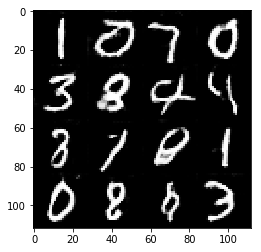

Epoch 2/2... Discriminator Loss: 1.9016... Generator Loss: 0.2163
Epoch 2/2... Discriminator Loss: 1.8926... Generator Loss: 0.5269
Epoch 2/2... Discriminator Loss: 2.3451... Generator Loss: 0.1223
Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 1.2597
Epoch 2/2... Discriminator Loss: 1.9362... Generator Loss: 0.2666
Epoch 2/2... Discriminator Loss: 1.9139... Generator Loss: 0.3001
Epoch 2/2... Discriminator Loss: 2.9333... Generator Loss: 0.0844
Epoch 2/2... Discriminator Loss: 1.9489... Generator Loss: 0.2684
Epoch 2/2... Discriminator Loss: 2.2392... Generator Loss: 0.1638
Epoch 2/2... Discriminator Loss: 1.5943... Generator Loss: 0.4085


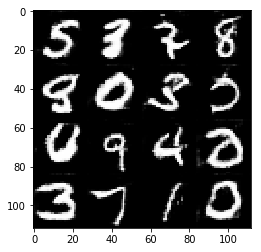

Epoch 2/2... Discriminator Loss: 1.4078... Generator Loss: 0.5368
Epoch 2/2... Discriminator Loss: 2.3859... Generator Loss: 0.1405
Epoch 2/2... Discriminator Loss: 1.9174... Generator Loss: 0.2656
Epoch 2/2... Discriminator Loss: 2.0982... Generator Loss: 0.2109
Epoch 2/2... Discriminator Loss: 1.6588... Generator Loss: 0.3929
Epoch 2/2... Discriminator Loss: 2.0055... Generator Loss: 0.3732
Epoch 2/2... Discriminator Loss: 1.7847... Generator Loss: 0.2295
Epoch 2/2... Discriminator Loss: 2.1851... Generator Loss: 0.1687
Epoch 2/2... Discriminator Loss: 2.2478... Generator Loss: 0.1546
Epoch 2/2... Discriminator Loss: 1.7651... Generator Loss: 0.5146


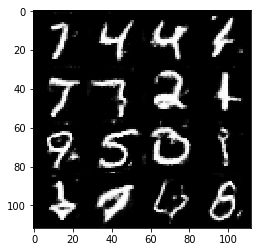

Epoch 2/2... Discriminator Loss: 1.8925... Generator Loss: 0.2379
Epoch 2/2... Discriminator Loss: 1.3379... Generator Loss: 0.5473
Epoch 2/2... Discriminator Loss: 2.3025... Generator Loss: 0.1588
Epoch 2/2... Discriminator Loss: 1.9953... Generator Loss: 0.2963
Epoch 2/2... Discriminator Loss: 2.3509... Generator Loss: 0.1624
Epoch 2/2... Discriminator Loss: 2.0833... Generator Loss: 0.6173
Epoch 2/2... Discriminator Loss: 2.0782... Generator Loss: 0.1748
Epoch 2/2... Discriminator Loss: 1.5760... Generator Loss: 0.3615
Epoch 2/2... Discriminator Loss: 2.1097... Generator Loss: 0.2392
Epoch 2/2... Discriminator Loss: 2.6887... Generator Loss: 0.1061


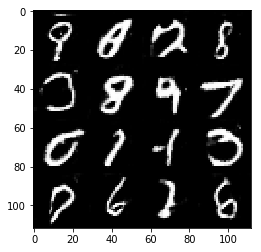

Epoch 2/2... Discriminator Loss: 2.1148... Generator Loss: 0.2156
Epoch 2/2... Discriminator Loss: 1.5919... Generator Loss: 0.3671
Epoch 2/2... Discriminator Loss: 1.6449... Generator Loss: 0.3261
Epoch 2/2... Discriminator Loss: 2.1055... Generator Loss: 0.1708
Epoch 2/2... Discriminator Loss: 2.8210... Generator Loss: 0.0847
Epoch 2/2... Discriminator Loss: 1.7792... Generator Loss: 0.7521
Epoch 2/2... Discriminator Loss: 1.7324... Generator Loss: 0.4113
Epoch 2/2... Discriminator Loss: 2.0900... Generator Loss: 0.1920
Epoch 2/2... Discriminator Loss: 2.3703... Generator Loss: 0.1450
Epoch 2/2... Discriminator Loss: 2.3870... Generator Loss: 0.1356


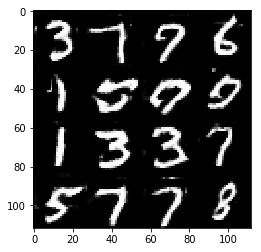

Epoch 2/2... Discriminator Loss: 1.8105... Generator Loss: 0.3874
Epoch 2/2... Discriminator Loss: 1.9603... Generator Loss: 0.2926
Epoch 2/2... Discriminator Loss: 1.9022... Generator Loss: 0.2424
Epoch 2/2... Discriminator Loss: 1.9151... Generator Loss: 0.9096
Epoch 2/2... Discriminator Loss: 1.5799... Generator Loss: 0.4832
Epoch 2/2... Discriminator Loss: 1.9642... Generator Loss: 0.1945
Epoch 2/2... Discriminator Loss: 2.8047... Generator Loss: 0.0858
Epoch 2/2... Discriminator Loss: 2.4292... Generator Loss: 0.1242
Epoch 2/2... Discriminator Loss: 2.3861... Generator Loss: 0.1228
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 1.0244


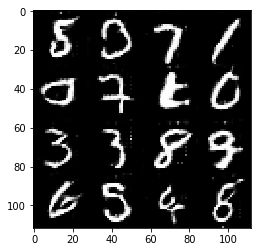

Epoch 2/2... Discriminator Loss: 2.9194... Generator Loss: 0.0907
Epoch 2/2... Discriminator Loss: 2.8271... Generator Loss: 0.0801
Epoch 2/2... Discriminator Loss: 2.4359... Generator Loss: 0.1322
Epoch 2/2... Discriminator Loss: 1.4465... Generator Loss: 0.8413
Epoch 2/2... Discriminator Loss: 1.7137... Generator Loss: 0.3318
Epoch 2/2... Discriminator Loss: 2.3368... Generator Loss: 0.1331
Epoch 2/2... Discriminator Loss: 2.2154... Generator Loss: 0.1587
Epoch 2/2... Discriminator Loss: 2.1167... Generator Loss: 0.1993
Epoch 2/2... Discriminator Loss: 2.0933... Generator Loss: 0.3257
Epoch 2/2... Discriminator Loss: 2.1120... Generator Loss: 0.4603


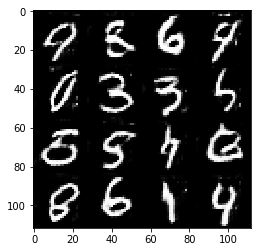

Epoch 2/2... Discriminator Loss: 3.0431... Generator Loss: 0.0750
Epoch 2/2... Discriminator Loss: 1.8122... Generator Loss: 0.3362
Epoch 2/2... Discriminator Loss: 1.7001... Generator Loss: 0.4189
Epoch 2/2... Discriminator Loss: 2.0820... Generator Loss: 0.2353
Epoch 2/2... Discriminator Loss: 2.3283... Generator Loss: 0.1727
Epoch 2/2... Discriminator Loss: 2.1261... Generator Loss: 0.2056
Epoch 2/2... Discriminator Loss: 2.3343... Generator Loss: 0.1467
Epoch 2/2... Discriminator Loss: 2.0126... Generator Loss: 0.2239
Epoch 2/2... Discriminator Loss: 2.0583... Generator Loss: 0.2077
Epoch 2/2... Discriminator Loss: 1.9231... Generator Loss: 0.2227


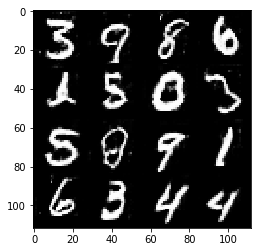

Epoch 2/2... Discriminator Loss: 2.6070... Generator Loss: 0.1619
Epoch 2/2... Discriminator Loss: 1.7502... Generator Loss: 0.2973
Epoch 2/2... Discriminator Loss: 2.2902... Generator Loss: 0.1644
Epoch 2/2... Discriminator Loss: 2.0741... Generator Loss: 0.2620
Epoch 2/2... Discriminator Loss: 2.7574... Generator Loss: 0.1025
Epoch 2/2... Discriminator Loss: 1.7659... Generator Loss: 0.3585
Epoch 2/2... Discriminator Loss: 2.1096... Generator Loss: 0.2063
Epoch 2/2... Discriminator Loss: 1.8696... Generator Loss: 0.6168
Epoch 2/2... Discriminator Loss: 2.0280... Generator Loss: 0.2327
Epoch 2/2... Discriminator Loss: 2.1049... Generator Loss: 0.2296


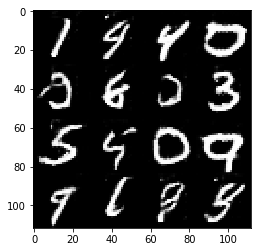

Epoch 2/2... Discriminator Loss: 2.5387... Generator Loss: 0.1217
Epoch 2/2... Discriminator Loss: 1.9434... Generator Loss: 0.5817
Epoch 2/2... Discriminator Loss: 1.5255... Generator Loss: 0.5753
Epoch 2/2... Discriminator Loss: 1.9282... Generator Loss: 0.2226
Epoch 2/2... Discriminator Loss: 2.1805... Generator Loss: 0.1562
Epoch 2/2... Discriminator Loss: 2.2056... Generator Loss: 0.1921
Epoch 2/2... Discriminator Loss: 2.7270... Generator Loss: 0.1835
Epoch 2/2... Discriminator Loss: 2.2866... Generator Loss: 0.1765
Epoch 2/2... Discriminator Loss: 2.2881... Generator Loss: 0.1771
Epoch 2/2... Discriminator Loss: 2.8298... Generator Loss: 0.0927


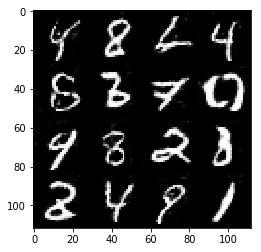

Epoch 2/2... Discriminator Loss: 2.0823... Generator Loss: 0.2266
Epoch 2/2... Discriminator Loss: 1.8678... Generator Loss: 0.3039
Epoch 2/2... Discriminator Loss: 2.3291... Generator Loss: 0.1783
Epoch 2/2... Discriminator Loss: 1.8548... Generator Loss: 0.3248
Epoch 2/2... Discriminator Loss: 1.6803... Generator Loss: 0.4809
Epoch 2/2... Discriminator Loss: 2.0447... Generator Loss: 0.2364
Epoch 2/2... Discriminator Loss: 1.4433... Generator Loss: 0.6137
Epoch 2/2... Discriminator Loss: 1.6034... Generator Loss: 0.4836
Epoch 2/2... Discriminator Loss: 2.3620... Generator Loss: 0.1578
Epoch 2/2... Discriminator Loss: 1.9128... Generator Loss: 0.2151


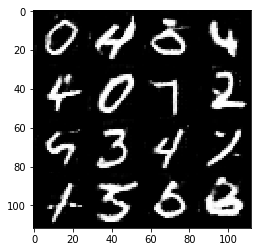

Epoch 2/2... Discriminator Loss: 2.1100... Generator Loss: 0.1998
Epoch 2/2... Discriminator Loss: 2.4162... Generator Loss: 0.1311
Epoch 2/2... Discriminator Loss: 1.5525... Generator Loss: 1.1868
Epoch 2/2... Discriminator Loss: 2.6903... Generator Loss: 0.1173
Epoch 2/2... Discriminator Loss: 1.6372... Generator Loss: 0.3616
Epoch 2/2... Discriminator Loss: 2.1957... Generator Loss: 0.1592
Epoch 2/2... Discriminator Loss: 2.1116... Generator Loss: 0.1713
Epoch 2/2... Discriminator Loss: 1.8501... Generator Loss: 0.2645
Epoch 2/2... Discriminator Loss: 1.6254... Generator Loss: 0.3308
Epoch 2/2... Discriminator Loss: 2.2475... Generator Loss: 0.1878


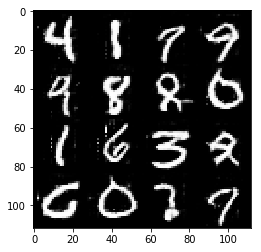

Epoch 2/2... Discriminator Loss: 2.2657... Generator Loss: 0.1723
Epoch 2/2... Discriminator Loss: 2.0254... Generator Loss: 0.2117
Epoch 2/2... Discriminator Loss: 2.6582... Generator Loss: 0.1004
Epoch 2/2... Discriminator Loss: 1.4271... Generator Loss: 0.5064
Epoch 2/2... Discriminator Loss: 1.8012... Generator Loss: 0.4396


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.9374... Generator Loss: 0.0092
Epoch 1/1... Discriminator Loss: 4.4405... Generator Loss: 0.0177
Epoch 1/1... Discriminator Loss: 3.1377... Generator Loss: 0.0813
Epoch 1/1... Discriminator Loss: 3.4350... Generator Loss: 0.0470
Epoch 1/1... Discriminator Loss: 3.1140... Generator Loss: 0.0745
Epoch 1/1... Discriminator Loss: 2.6772... Generator Loss: 0.1289
Epoch 1/1... Discriminator Loss: 2.4018... Generator Loss: 0.1903
Epoch 1/1... Discriminator Loss: 2.3332... Generator Loss: 0.1927
Epoch 1/1... Discriminator Loss: 2.4727... Generator Loss: 0.2272
Epoch 1/1... Discriminator Loss: 2.4252... Generator Loss: 0.1668


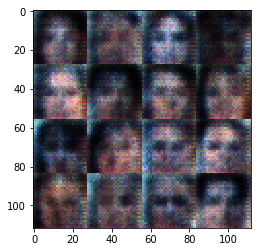

Epoch 1/1... Discriminator Loss: 2.2647... Generator Loss: 0.2210
Epoch 1/1... Discriminator Loss: 2.1198... Generator Loss: 0.2327
Epoch 1/1... Discriminator Loss: 2.0794... Generator Loss: 0.3154
Epoch 1/1... Discriminator Loss: 2.2808... Generator Loss: 0.2843
Epoch 1/1... Discriminator Loss: 2.2188... Generator Loss: 0.2300
Epoch 1/1... Discriminator Loss: 2.4589... Generator Loss: 0.2125
Epoch 1/1... Discriminator Loss: 2.2535... Generator Loss: 0.2232
Epoch 1/1... Discriminator Loss: 2.2678... Generator Loss: 0.3449
Epoch 1/1... Discriminator Loss: 1.8390... Generator Loss: 0.3983
Epoch 1/1... Discriminator Loss: 1.8300... Generator Loss: 0.3681


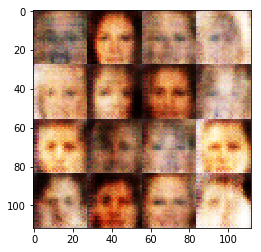

Epoch 1/1... Discriminator Loss: 1.9490... Generator Loss: 0.3689
Epoch 1/1... Discriminator Loss: 1.7223... Generator Loss: 0.4237
Epoch 1/1... Discriminator Loss: 1.8134... Generator Loss: 0.3636
Epoch 1/1... Discriminator Loss: 1.9115... Generator Loss: 0.4062
Epoch 1/1... Discriminator Loss: 1.8927... Generator Loss: 0.3486
Epoch 1/1... Discriminator Loss: 1.9341... Generator Loss: 0.3415
Epoch 1/1... Discriminator Loss: 1.9077... Generator Loss: 0.3930
Epoch 1/1... Discriminator Loss: 1.7518... Generator Loss: 0.4299
Epoch 1/1... Discriminator Loss: 1.8111... Generator Loss: 0.4213
Epoch 1/1... Discriminator Loss: 1.7453... Generator Loss: 0.4702


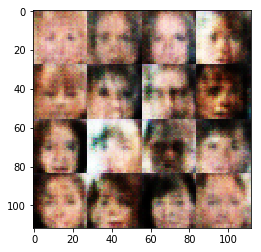

Epoch 1/1... Discriminator Loss: 1.7320... Generator Loss: 0.4661
Epoch 1/1... Discriminator Loss: 1.7437... Generator Loss: 0.4739
Epoch 1/1... Discriminator Loss: 1.6985... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.6125... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.6399... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.7627... Generator Loss: 0.4146
Epoch 1/1... Discriminator Loss: 1.6306... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.5237


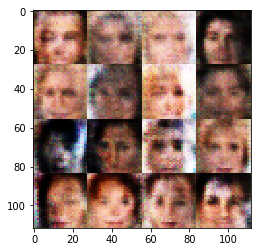

Epoch 1/1... Discriminator Loss: 1.7190... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 1.6083... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.6301... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.6200... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.6019... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.6373... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.6321... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.6101... Generator Loss: 0.5293


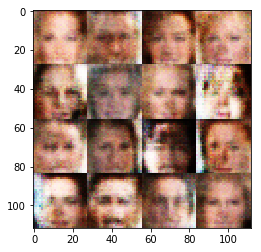

Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.6550... Generator Loss: 0.5104
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.6687... Generator Loss: 0.5071
Epoch 1/1... Discriminator Loss: 1.5771... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.6523... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 1.6744... Generator Loss: 0.4550
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.5435


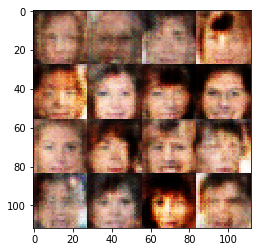

Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.6226... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.6977... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.5957... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.5871... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.6262... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.6583... Generator Loss: 0.4998


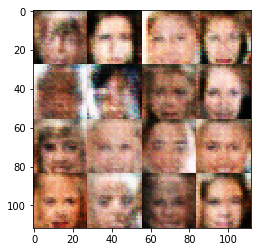

Epoch 1/1... Discriminator Loss: 1.6524... Generator Loss: 0.5237
Epoch 1/1... Discriminator Loss: 1.6134... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.6094... Generator Loss: 0.5061
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.5761... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.5818... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 0.5092


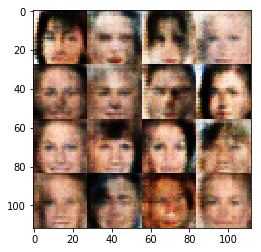

Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.5921... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.5441
Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.6406... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 0.5790


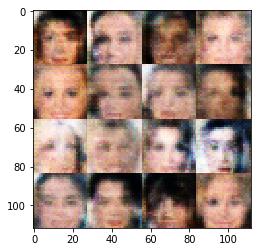

Epoch 1/1... Discriminator Loss: 1.6829... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 1.5755... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.5966... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 1.5937... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.5844


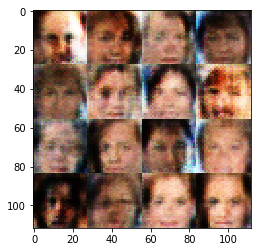

Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.5615... Generator Loss: 0.4990


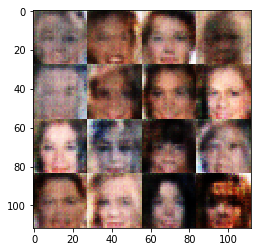

Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.5395
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.5706... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 1.5764... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.6023... Generator Loss: 0.5281


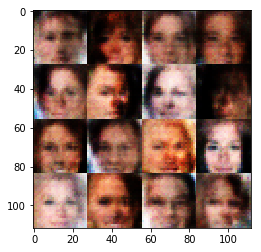

Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.5810... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.5784... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.5969


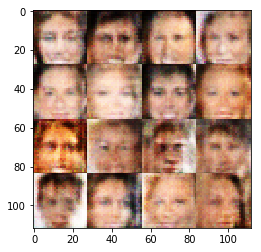

Epoch 1/1... Discriminator Loss: 1.5570... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.6232


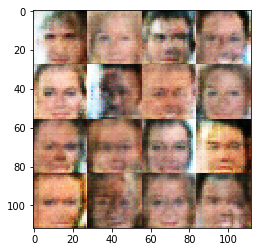

Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.6543... Generator Loss: 0.4851
Epoch 1/1... Discriminator Loss: 1.6569... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.6131


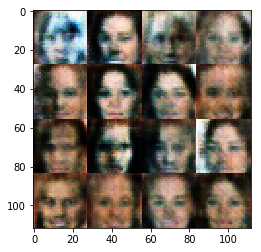

Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.5558


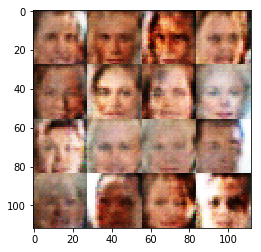

Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.6296


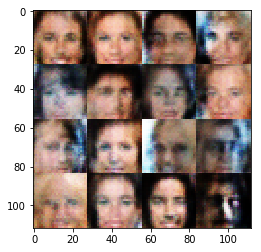

Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.6076


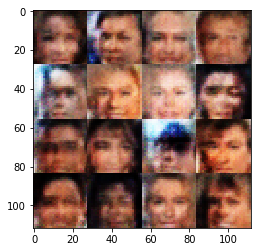

Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.5372
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6210


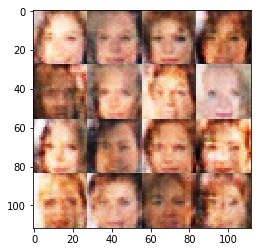

Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.5005
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.5464


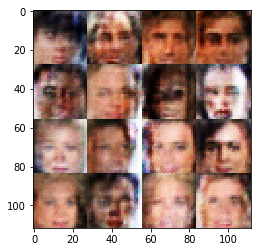

Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.5715
Epoch 1/1... Discriminator Loss: 1.5370... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.6079


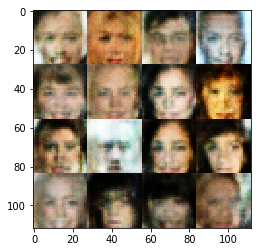

Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.5677


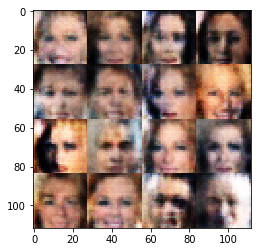

Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.6361


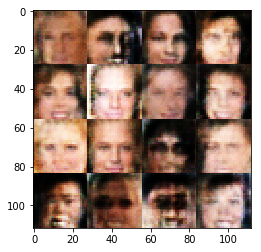

Epoch 1/1... Discriminator Loss: 1.5854... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6174


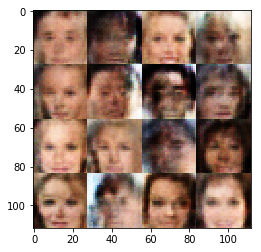

Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6198


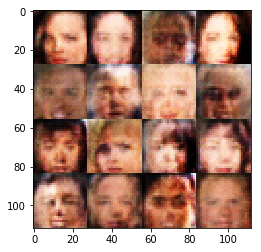

Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.5611


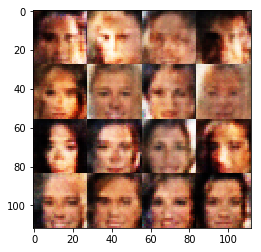

Epoch 1/1... Discriminator Loss: 1.5602... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6063


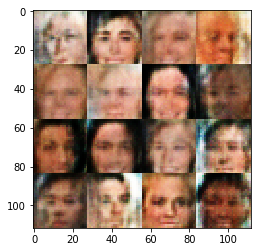

Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.6088


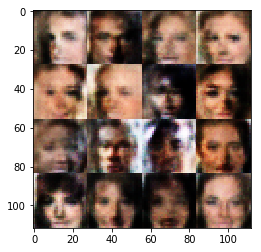

Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.5350


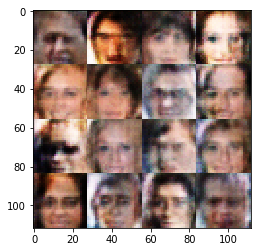

Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6207


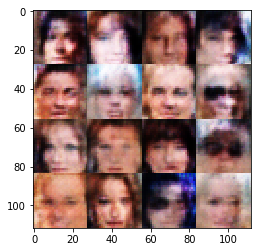

Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.6132


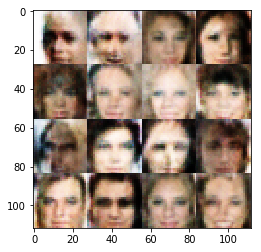

Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.5931


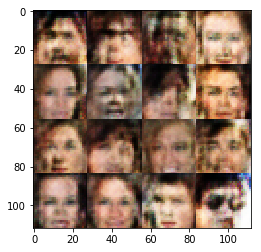

Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.6299


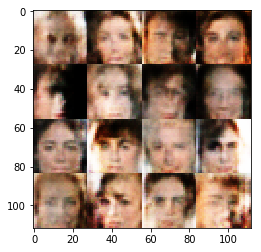

Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6177


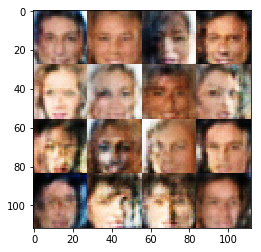

Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6507


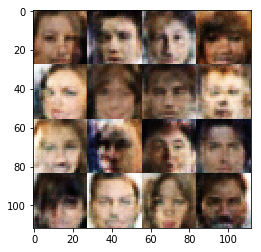

Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.5478


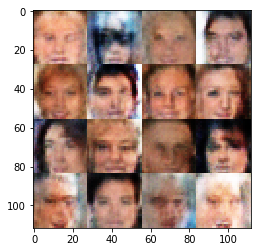

Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.5836
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.5699


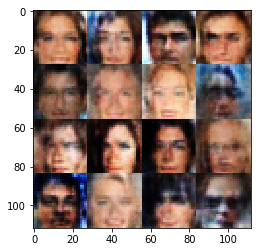

Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.5946


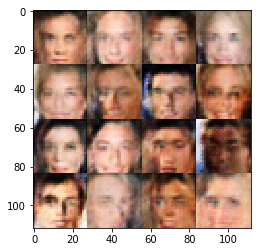

Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6036


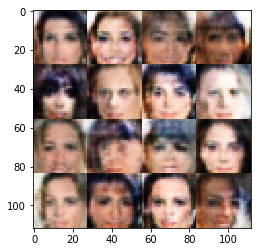

Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6422


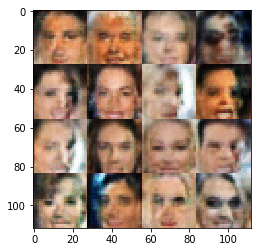

Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6587


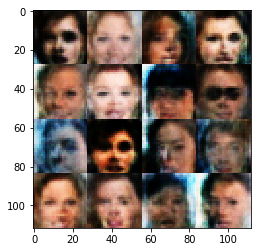

Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6252


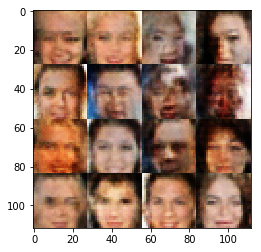

Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6032


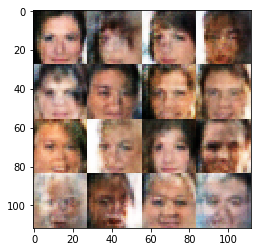

Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6761


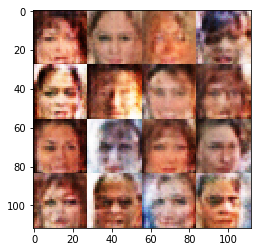

Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.6132


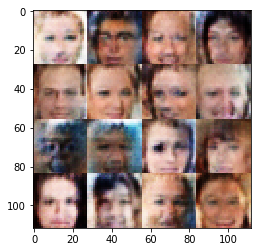

Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6410


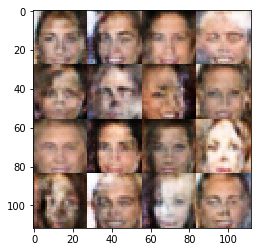

Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6078


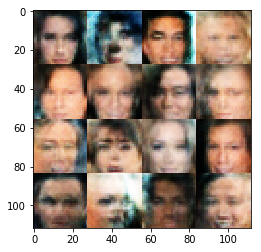

Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6775


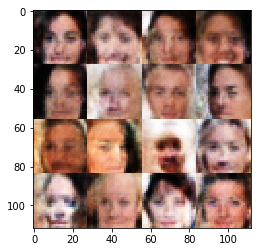

Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.6602


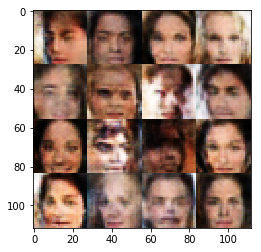

Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.5877


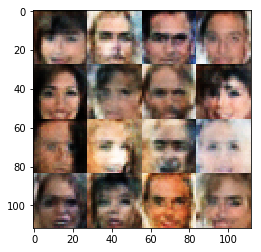

Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6658


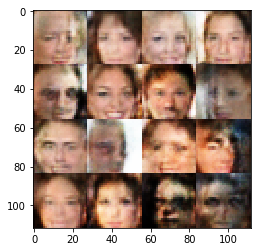

Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6415


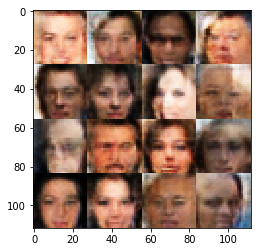

Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6258


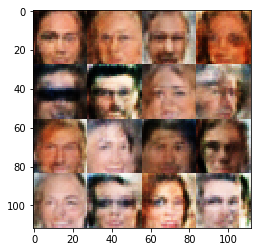

Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.6610


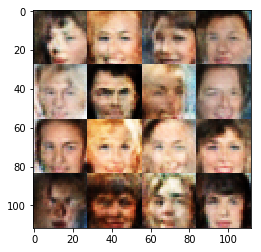

Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6502


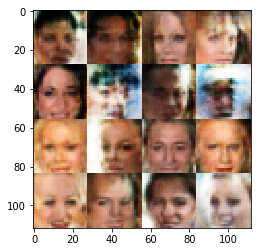

Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6984


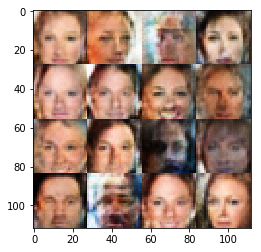

Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6531


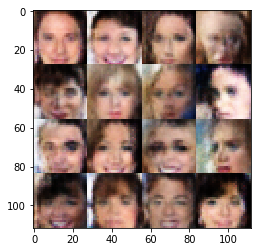

Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6319


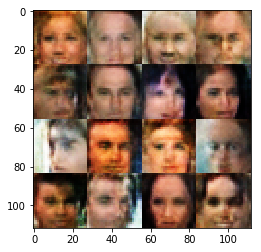

Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6449


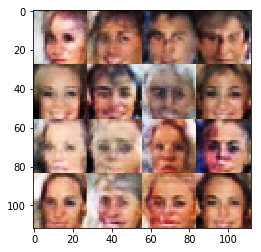

Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6811


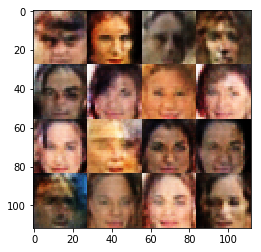

Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7133


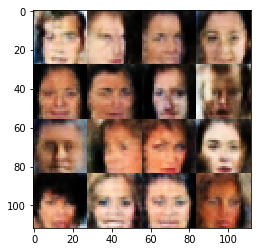

Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6172


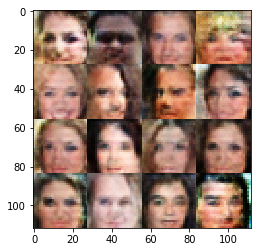

Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6534


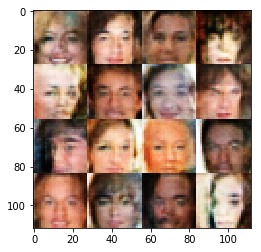

Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6735


In [17]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.